# Image Classification Using HOG+SVM 

In this we will use Crack-Non Crack Images Dataset. It contains more than 20k images, but for this example i am considering 1k only.  The goal is to train Support Vector Machines using HOG features of images. The process is follows:
*  Read Image.
*  Find HOG features of image.
*  Train SVC on features vector.
*  Predict with SVCs.



In [5]:
from PIL import Image
import cv2, os
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from skimage import feature, exposure
import imutils
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15,8)


In [13]:
!wget -P /content/ https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip

In [3]:
!unzip --qq /content/concrete_crack_images_for_classification.zip

replace Negative/18476.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Show Images

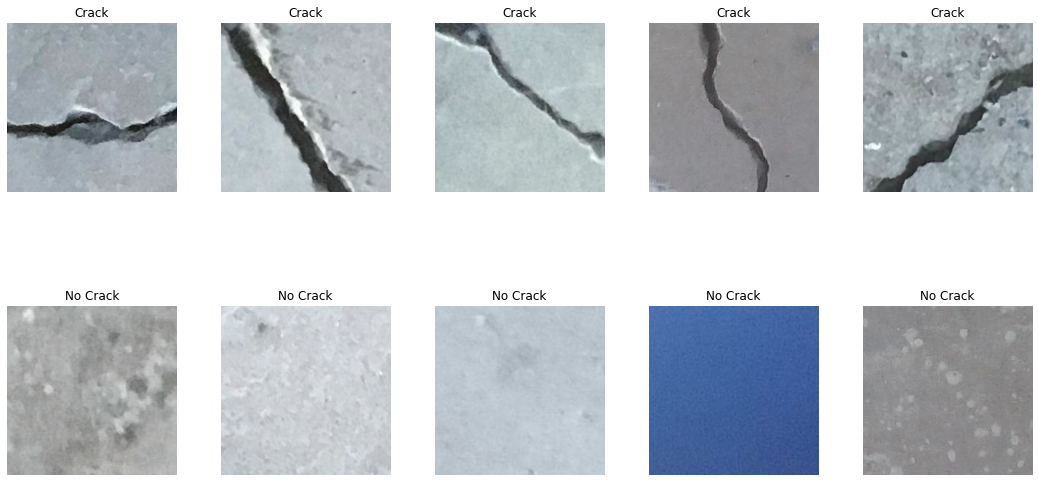

In [6]:
# sample some images
p1 = "/content/Positive/"
image_ids = [p1+i for i in os.listdir("/content/Positive")[:5]]
p2 = "/content/Negative/"
image_ids = image_ids + [p2+j for j in os.listdir("/content/Negative")[:5]]
labels = ["Crack"]*5 + ["No Crack"]*5

r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    im = cv2.imread(image_ids[a])
    axs[i,j].imshow(im)
    axs[i,j].set_title(labels[a])
    axs[i,j].axis('off')
    a+=1

In [29]:
# image size
cv2.imread(image_ids[0]).shape

(227, 227, 3)

## Make Dataset

In [3]:
no_crack_path = ['/content/Negative/'+ i for i in os.listdir('/content/Negative')][:500]
crack_path = ['/content/Positive/'+ i for i in os.listdir('/content/Positive')][:500]

images_path = crack_path + no_crack_path
labels = [1]*len(no_crack_path) + [0]*len(crack_path)

X_train, X_test, Y_train, Y_test = train_test_split(images_path, labels, test_size= 0.3)

print('Total Train samples:', len(Y_train))
print('Total Test samples:', len(Y_test))

Total Train samples: 700
Total Test samples: 300


## Show HOG images sample 

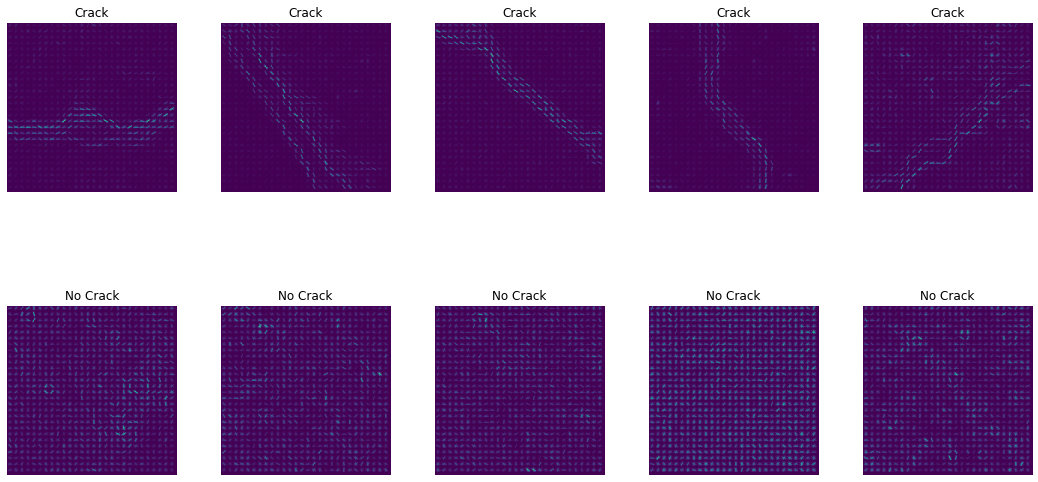

In [7]:
r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    img = cv2.imread(image_ids[a])
    HOG_features, Hog_image = feature.hog(img, 9, visualize=True, 
                                          pixels_per_cell=(8,8), cells_per_block=(2,2), 
                                          feature_vector=True)
    img = exposure.rescale_intensity(Hog_image, out_range=(0, 255))
    axs[i,j].imshow(img)
    axs[i,j].set_title(labels[a])
    axs[i,j].axis('off')
    a+=1

## Prepare hog features

In [8]:
def get_hog_feaures(image):
  # image values is already normalized under hog function
  Hog_features = feature.hog(image, orientations=9, 
                          pixels_per_cell=(8,8), cells_per_block=(2,2), 
                            feature_vector=True)
  return Hog_features

In [9]:
# read image, get HOG features

train_features = []

for image in X_train: # non-preprocessed
  image = cv2.imread(image, cv2.COLOR_BGR2GRAY)
  hog_features = get_hog_feaures(image)
  train_features.append(hog_features)  

In [ ]:
# train a svm on them

svc1 = LinearSVC(tol=0.0001, random_state=42)
svc1 = svc1.fit(train_features, Y_train)

In [12]:
# predict with svm

correct = 0

for image,label in zip(X_test, Y_test):
  image = cv2.imread(image, cv2.COLOR_BGR2GRAY)
  features = make_hog_feaures(image)
  yhat = svc1.predict((features).reshape(1, features.shape[0]))
  if yhat[0] == label:
    correct+=1

print('{0} Correct out of {1}'.format(correct, len(Y_test)))   
print("Accuracy:", correct/len(Y_test)*100)

265 Correct out of 300
Accuracy: 88.33333333333333


## Method 2

If image size is larger, use canny detector to find edges, take largest edge and make egde map out of it. Then make HOG features.

In [25]:
# preprocessing such as finding edges and taking largest egde and make edge map out of it

not_processed = 0

def preprocess_image(image):
  global not_processed
  edges = cv2.Canny(image, 100, 100)
  cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  if cnts:
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
    img = image[y:y + h, x:x + w]
    img = cv2.resize(img, (227, 227))
    return img
  else:
    not_processed+=1
    return image  

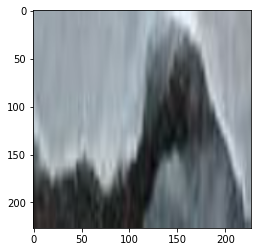

In [34]:
# edge map example
plt.rcParams["figure.figsize"] = (8,4)

img = cv2.imread(image_ids[0])
img = preprocess_image(img)
hog_features = make_hog_feaures(img)
plt.imshow(img)
plt.show()

In [29]:
prec_train_features = []

for image in X_train: # preprocessed
  image = cv2.imread(image, cv2.COLOR_BGR2GRAY)
  image = preprocess_image(image)
  hog_features = get_hog_feaures(image)
  prec_train_features.append(hog_features)

In [30]:
# train a svc2 

svc2 = LinearSVC(tol=0.0001, random_state=42)
svc2 = svc2.fit(prec_train_features, Y_train)

In [31]:
# predict with SVC2

correct = 0

for image,label in zip(X_test, Y_test):
  image = cv2.imread(image, cv2.COLOR_BGR2GRAY)
  image = preprocess_image(image)
  features = make_hog_feaures(image)
  yhat = svc2.predict((features).reshape(1, features.shape[0]))
  if yhat[0] == label:
    correct+=1

print('{0} Correct out of {1}'.format(correct, len(Y_test)))   
print("Accuracy:", correct/len(Y_test)*100)

245 Correct out of 300
Accuracy: 81.66666666666667


If the accuracy is very low, it might be becuase the image size was very small, becuase of which Canny could not find good edges.

## Show results

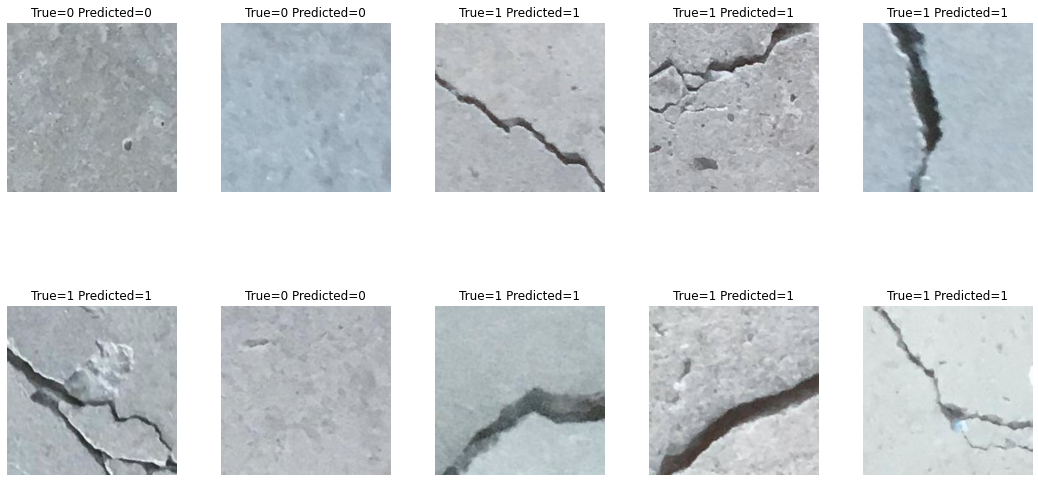

In [24]:
# SVC results
plt.rcParams["figure.figsize"] = (12,8)

a = 0
f, axs = plt.subplots(2, 5)
f.tight_layout()
for i in range(r):
  for j in range(c):
    image = cv2.imread(X_test[a], cv2.COLOR_BGR2GRAY)
    features = make_hog_feaures(image)
    yhat = svc1.predict((features).reshape(1, features.shape[0]))
    axs[i,j].imshow(image, cmap='gray')
    axs[i,j].set_title("True={0} Predicted={1}".format(Y_test[a], yhat[0]))
    axs[i,j].axis('off')
    a+=1

**Summary**: Even though the not pre-processed dataset did well with this example does not means this is always going to be the case. This Dataset was very easy and did not had complex differences in images(like objects, variations, lightning conditions).  Few things to learn here:
* This is method proves to be benificial when processing requirements are low(pi devices)
* Preprocess(finding edges) don't do well in smaller size images.
* As always many things depend on input dataset quality.
* This method can be used to recognize faces also, but fairly amount of images per face is a good requirement. 
